# Installs

In [1]:
# conda install -c conda-forge wordcloud

# Imports

In [2]:
import pandas as pd
import re
import glob
from textblob import TextBlob
import nltk
import string
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from gensim.models import Word2Vec 
from gensim.parsing.preprocessing import remove_stopwords
from sklearn.cluster import KMeans, DBSCAN
from sklearn.feature_extraction.text import TfidfVectorizer
from yellowbrick.cluster import KElbowVisualizer

/opt/anaconda3/envs/Python_and_R/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


# Read in Files
[Data Source](https://archive.ics.uci.edu/ml/datasets/Health+News+in+Twitter)

In [3]:
start = "../Datasets/Health-Tweets"
files = []

dfs = []
headers = []

for name in glob.glob("{}/*.txt".format(start), recursive=True): 
    break # Just read from 
    print(name)
    
    # UTF-8 Encoding
    try:
        with open(name, 'r', encoding="utf8") as file:
            data = file.read()
            files.append(name)
           
    # Windows encoding,
    except:
        with open(name, 'r', encoding='cp1252') as file:
            data = file.read()
            files.append(name)
            
    # Save contents into dfs, then concat into one big df
    temp = pd.DataFrame(columns=["tweet id", "date and time", "tweet", "source_file"])
    for line in data.split("\n"):
        try:
            tweet = line.split("|")
            row = {"tweet id":tweet[0], "date and time":tweet[1], "tweet":tweet[2], "source_file":name}
            temp = temp.append(row, ignore_index=True)
        # Just an EOF character
        except:
            continue
            
    dfs.append(temp)
    

In [4]:
# df = pd.concat(dfs, ignore_index=True)
df = pd.read_csv("../Datasets/df.csv")
# df

In [5]:
# df[["tweet id", "date and time", "tweet", "source_file"]].to_csv("../Datasets/df.csv", index=False)
# df.to_csv("../Datasets/df.csv", index=False)
# df["tweet"].to_csv("../Datasets/all_tweets.csv", index=False)

# Clean the data of URL's, RT's, and Hyperlinks

In [6]:
#df[[('RT' in s) and ('@' in s) for s in df["tweet"]]]
# df["tweet"][3969]

In [7]:
def clean_tweet(t):
    # Regular Expressions
    t = re.sub(r"RT ", "", t)         # Retweet 
    t = re.sub(r" http[\S]+" , "", t) # Hyperlinks
    t = re.sub(r"@[\S]+ " , "", t)    # Mentions
    t = re.sub(r"#" , "", t)          # Hastags
    
    return t.lower()
    
df["tweet"] = df["tweet"].apply(clean_tweet)

In [8]:
df["tweet"][3969]

'health canada suspends two natural health product licences due to potential serious risks of male fern'

# Using TextBlob for Subjectivity and Polarity
    Polarity
        - range = [-1.0, 1.0]
        - low values imply negative text 
        - high values imply positve text
    Subjectivity
        - range = [0.0, 1.0] 
        - low values imply objective text 
        - high values imply subjective text

In [9]:
def get_subj(t):
    return TextBlob(t).sentiment.subjectivity

def get_pol(t):
    return TextBlob(t).sentiment.polarity

df["Subjectivity"] = df["tweet"].apply(get_subj)
df["Polarity"] = df["tweet"].apply(get_pol)

In [10]:
df.head()

,tweet id,date and time,tweet,source_file,Subjectivity,Polarity
0,585978391360221184,Thu Apr 09 01:31:50 +0000 2015,breast cancer risk test devised,../Datasets/Health-Tweets/bbchealth.txt,0.000000,0.000000
1,585947808772960257,Wed Apr 08 23:30:18 +0000 2015,gp workload harming care - bma poll,../Datasets/Health-Tweets/bbchealth.txt,0.000000,0.000000
2,585947807816650752,Wed Apr 08 23:30:18 +0000 2015,short people's 'heart risk greater',../Datasets/Health-Tweets/bbchealth.txt,0.400000,0.250000
3,585866060991078401,Wed Apr 08 18:05:28 +0000 2015,new approach against hiv 'promising',../Datasets/Health-Tweets/bbchealth.txt,0.477273,0.168182
4,585794106170839041,Wed Apr 08 13:19:33 +0000 2015,coalition 'undermined nhs' - doctors,../Datasets/Health-Tweets/bbchealth.txt,0.000000,0.000000


In [11]:
df["tweet"].to_csv("../Datasets/all_tweets_cleaned.csv", index=False)

In [12]:
pd.DataFrame(df[["Subjectivity", "Polarity"]].describe())

,Subjectivity,Polarity
count,63326.000000,63326.000000
mean,0.278243,0.078562
std,0.306256,0.257582
min,0.000000,-1.000000
25%,0.000000,0.000000
50%,0.200000,0.000000
75%,0.500000,0.160000
max,1.000000,1.000000


array([[<AxesSubplot:title={'center':'Subjectivity'}>,
        <AxesSubplot:title={'center':'Polarity'}>]], dtype=object)

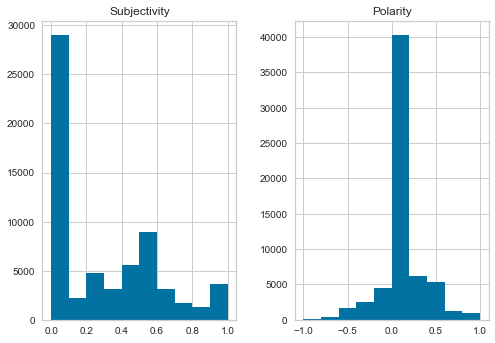

In [13]:
df[["Subjectivity", "Polarity"]].hist()

In [14]:
def clean_source(t):
    t = t.replace(start, "")
    t = t.replace(".txt", "")
    t = t.replace("\\", "")
    t = t.replace("/", "")
                  
    return t
    
df["source"] = df["source_file"].apply(clean_source)

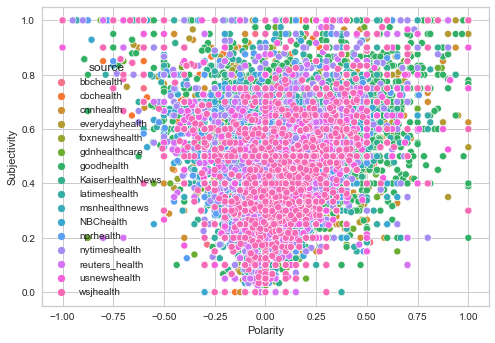

In [15]:
import seaborn as sns

# df_sample = df[(df["cluster"]==0)]
df_sample = df[["Subjectivity", "Polarity"]]
# df_sample = df_sample.sample(50)#, random_state=2020)

sns.scatterplot(data=df, 
                x=df["Polarity"], 
                y=df["Subjectivity"],
                hue=df["source"])

# for index, row in df_sample.iterrows():
#     #plt.annotate("Point 1", (1, 4))
#     plt.annotate(row["Word"],
#                  (row["Simailarity to {}".format(topic_1)],
#                   row["Simailarity to {}".format(topic_2)]))
    
plt.show()

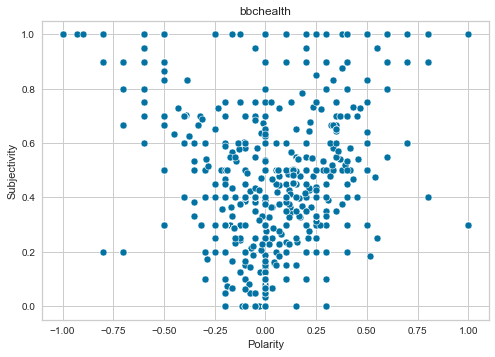

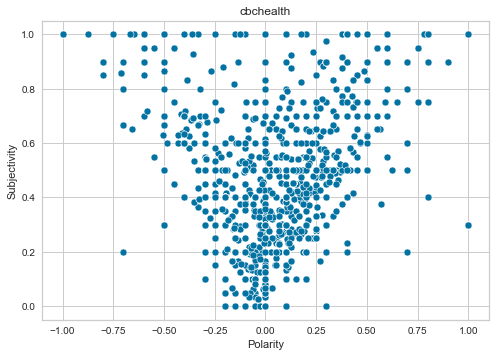

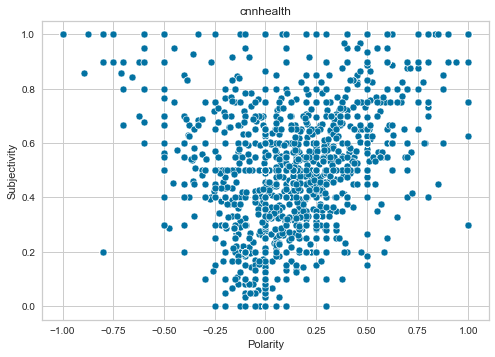

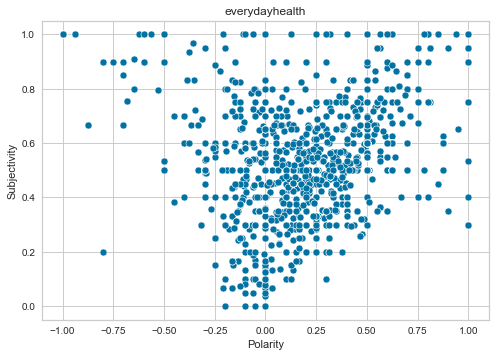

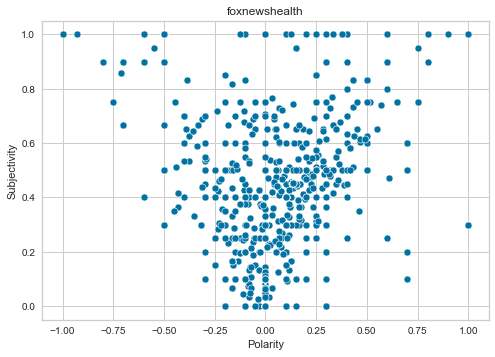

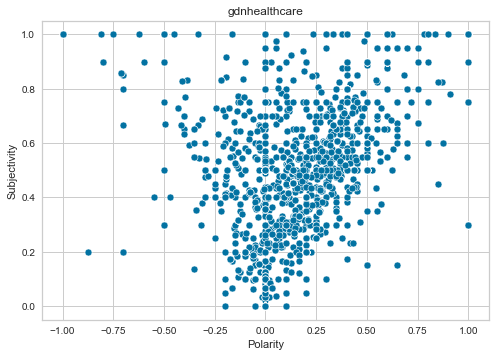

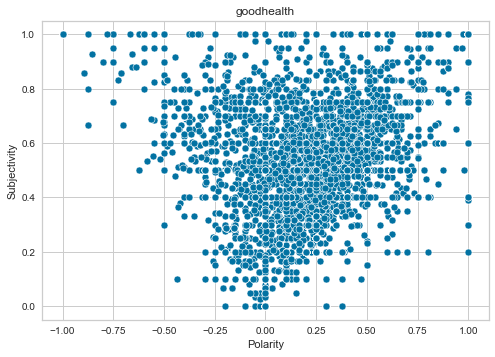

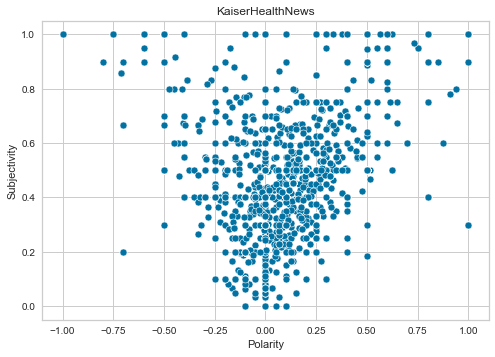

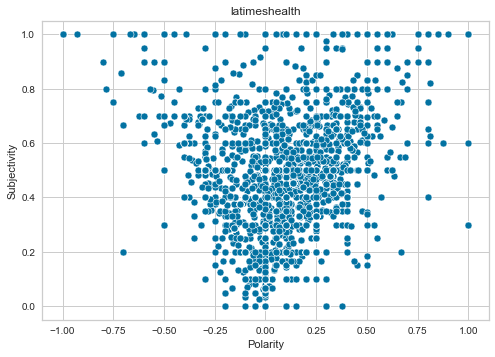

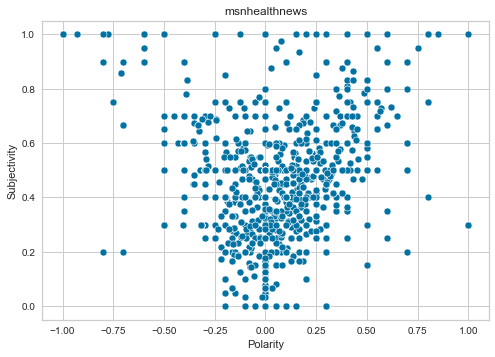

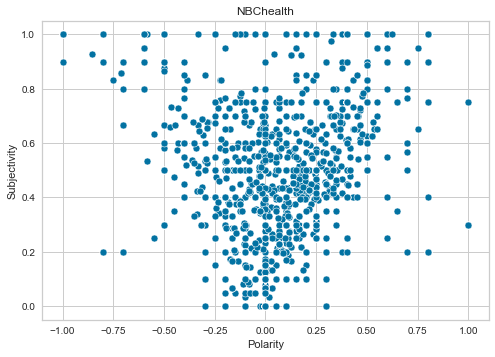

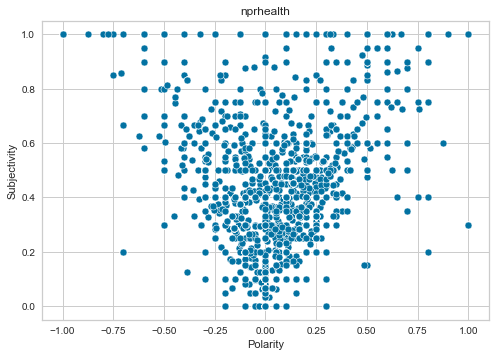

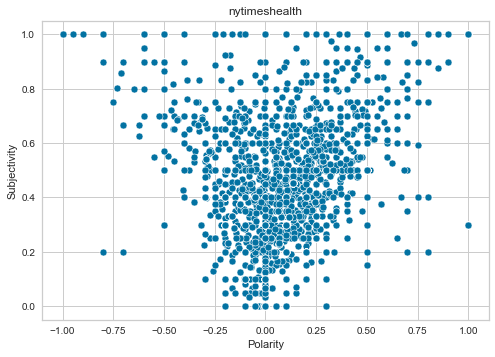

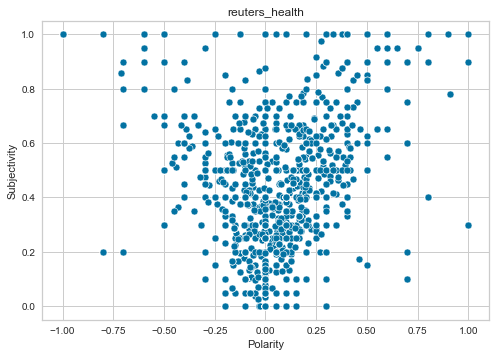

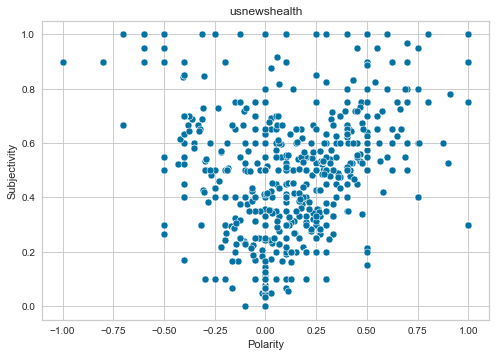

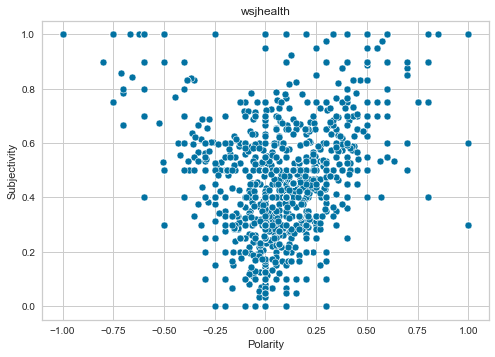

In [16]:
for s in df["source"].unique():
    df_sample = df[df["source"]==s]
    df_sample = df_sample[["Subjectivity", "Polarity", "source"]]
    sns.scatterplot(data=df_sample, 
                    x=df_sample["Polarity"], 
                    y=df_sample["Subjectivity"])
                    #hue=df_sample["source"])
    plt.title(s)

    # for index, row in df_sample.iterrows():
    #     #plt.annotate("Point 1", (1, 4))
    #     plt.annotate(row["Word"],
    #                  (row["Simailarity to {}".format(topic_1)],
    #                   row["Simailarity to {}".format(topic_2)]))

    plt.show()

# Saving df for Technical Notebook

In [17]:
df.to_csv("../Datasets/df_cleaned.csv", index=False)

# [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer.fit_transform)
    Rows:    Tweets
    Columns: Words
    Cells:   Term-frequency times inverse document-frequency
             TF * IDF

In [73]:
vect = TfidfVectorizer(min_df = .01,
                       stop_words = nltk.corpus.stopwords.words('english'),
                       ngram_range = (1,3))
df_tfidf = vect.fit_transform(df["tweet"]) # Tf-idf-weighted document-term matrix.
keys = list(vect.vocabulary_.keys())
# keys.sort()
# print((keys))
# print(len(keys))
df_tfidf = pd.DataFrame(df_tfidf.toarray())
df_tfidf

,0,1,2,3,4,5,6,7,8,9,...,65,66,67,68,69,70,71,72,73,74
0,0.0,0.0,0.0,0.0,0.0,0.678162,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63321,0.0,0.0,0.0,0.0,1.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
63322,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.823702,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
63323,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
63324,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Saving df_tfidf

In [74]:
# temp = df_tfidf.copy()
# temp.columns = keys
# temp.to_csv("../Datasets/df_tfidf.csv", index=False)
# temp

# Elbow Analysis to find best number of groups

### k in (1,12)

CPU times: user 49.9 s, sys: 4.93 s, total: 54.8 s
Wall time: 18.9 s


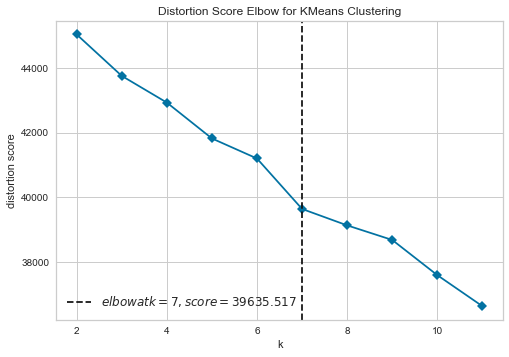

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [84]:
model = KMeans(random_state=2020)
visualizer = KElbowVisualizer(model, k=(2,12), metric='distortion', timings=False)

%time visualizer.fit(df_tfidf)
visualizer.show() 

CPU times: user 14min 6s, sys: 2min 54s, total: 17min 1s
Wall time: 12min 57s


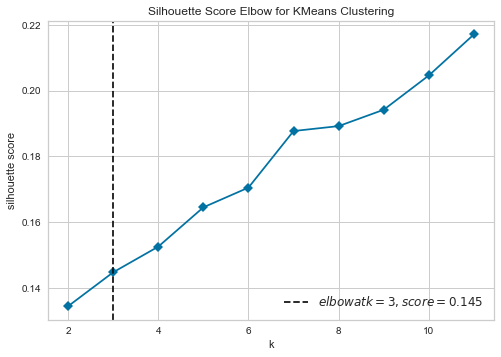

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [85]:
model = KMeans(random_state=2020)
visualizer = KElbowVisualizer(model, k=(2,12), metric='silhouette', timings=False)

%time visualizer.fit(df_tfidf)
visualizer.show() 

CPU times: user 54.1 s, sys: 4.56 s, total: 58.6 s
Wall time: 31.9 s


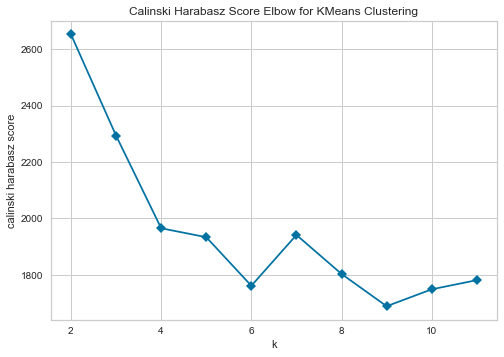

<AxesSubplot:title={'center':'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [87]:
model = KMeans(random_state=2020)
visualizer = KElbowVisualizer(model, k=(2,12), metric='calinski_harabasz', locate_elbow=False, timings=False)

%time visualizer.fit(df_tfidf)
visualizer.show() 

CPU times: user 50.9 s, sys: 4.5 s, total: 55.4 s
Wall time: 24.9 s


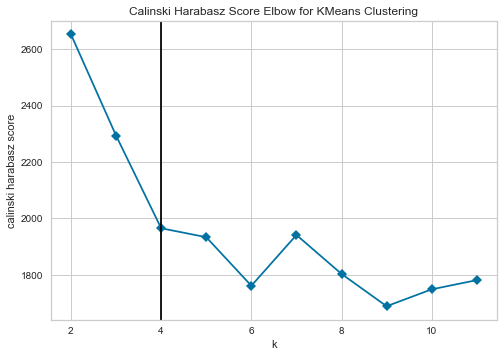

<AxesSubplot:title={'center':'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [86]:
model = KMeans(random_state=2020)
visualizer = KElbowVisualizer(model, k=(2,12), metric='calinski_harabasz', locate_elbow=False, timings=False)

%time visualizer.fit(df_tfidf)
plt.axvline(x=4, color="black")
visualizer.show() 

CPU times: user 49.6 s, sys: 4.51 s, total: 54.1 s
Wall time: 16.6 s


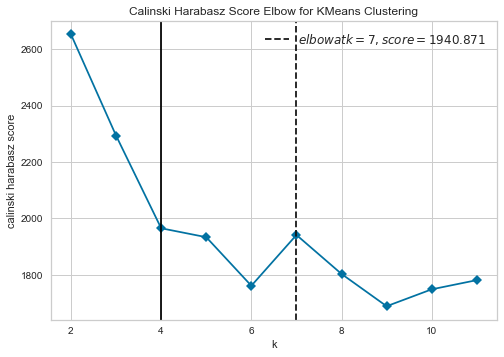

<AxesSubplot:title={'center':'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [83]:
model = KMeans(random_state=2020)
visualizer = KElbowVisualizer(model, k=(2,12), metric='calinski_harabasz', locate_elbow=True, timings=False)

%time visualizer.fit(df_tfidf)
plt.axvline(x=4, color="black")
visualizer.show()

# Cluster

In [88]:
num_clusters = 4

# model_km = KMeans(random_state=2020)
model_km = KMeans(n_clusters=num_clusters, random_state=2020)
model_km.fit(df_tfidf)

clusters = model_km.labels_.tolist()
print(len(set(clusters)))

df_tfidf["cluster"] = clusters

4


========================0=========================


,0,word
26,3028.173777,healthcare
37,478.443122,make
27,386.345797,medical
6,369.310490,nhs
34,303.776206,brain
44,295.164956,study
16,151.315314,food
42,102.877664,law
57,100.457712,many
24,94.674096,women


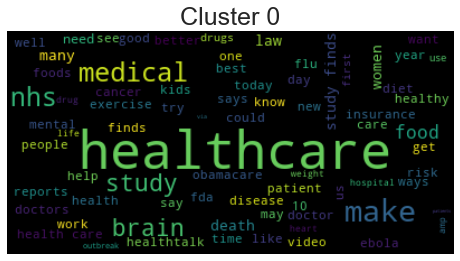

========================1=========================


,0,word
16,2765.035098,food
42,1814.170750,law
59,1490.135526,better
5,1431.719245,new
57,1259.836699,many
47,1069.243920,like
24,1067.134999,women
1,1056.705884,risk
71,1050.805562,obamacare
32,1002.155232,us


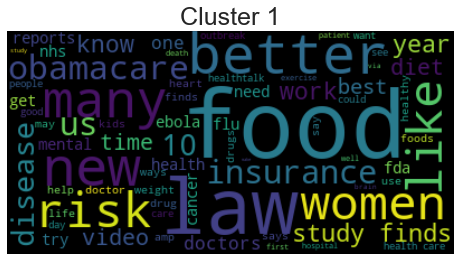

========================2=========================


,0,word
46,2113.963831,today
59,152.868817,better
16,140.703216,food
74,95.892858,healthtalk
26,93.845544,healthcare
47,87.141523,like
57,86.245778,many
19,81.001619,good
42,70.064653,law
18,67.202566,drug


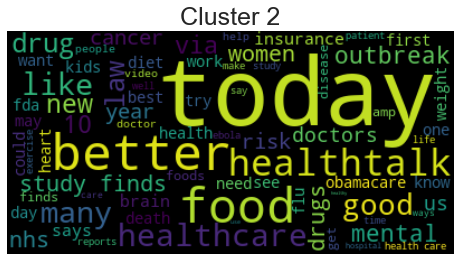

========================3=========================


,0,word
14,1157.818094,patients
18,121.618989,drug
5,114.319881,new
59,73.443764,better
46,68.793200,today
16,61.391165,food
57,42.291467,many
42,40.410114,law
65,38.352223,want
52,31.907815,year


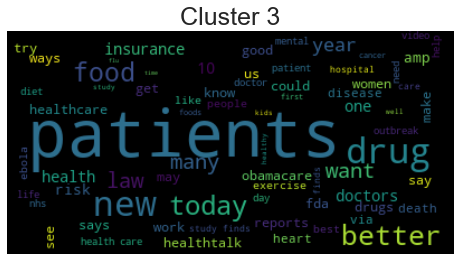

In [183]:
for c in set(df_tfidf["cluster"].tolist()):
    print("{:=^50}".format(c))
    temp = pd.DataFrame(df_tfidf[df_tfidf["cluster"]==c].drop(columns=["cluster"]).sum(axis=0))
    temp = temp.sort_values(by=0, ascending=False)
    temp["word"] = [keys[x] for x in temp.index.values]
    
    display(temp.head(10))    
    
    freq = {}
    for index, row in temp.iterrows():
        freq[row["word"]] = row[0]
    
    wordcloud = WordCloud().generate_from_frequencies(freq)

    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title("Cluster {}".format(c), fontsize=25)
    plt.savefig("../Images/Cluster_{}.png".format(c))
    plt.show()

# Plot

In [ ]:
df_sample = pd.merge(df, df_tfidf["cluster"], left_index=True, right_index=True)
# df_sample = df_sample.sample(50)#, random_state=2020)

sns.scatterplot(data=df_sample, 
                x=df_sample["Polarity"], 
                y=df_sample["Subjectivity"],
                hue=df_sample["cluster"])

# plt.show()

# Investigate what tweets make up the Clusters
https://stackoverflow.com/questions/17232013/how-to-set-the-pandas-dataframe-data-left-right-alignment

In [111]:
def left_align(df):
    left_aligned_df = df.style.set_properties(**{'text-align': 'left'})
    left_aligned_df = left_aligned_df.set_table_styles(
        [dict(selector='th', props=[('text-align', 'left')])]
    )
    return left_aligned_df

In [184]:
df = pd.read_csv("../Datasets/df_cleaned.csv")
df["cluster"] = clusters
df.to_csv("../Datasets/df_cleaned_clusters.csv")

### Healthcare

In [178]:
temp = df[df["cluster"]==0]
temp  = pd.DataFrame(temp[[('healthcare' in t) or 
                           ('make' in t) or 
                           ('medical' in t) for t in temp["tweet"]]])
display(left_align(temp.head(10)[["tweet", "source", "cluster"]]))

,tweet,source,cluster
1528,video: 'make mental health bigger priority',bbchealth,0
1530,make mental health 'bigger priority',bbchealth,0
4456,video: our panel of medical experts answers your health questions.,cbchealth,0
4610,health canada clamps down on medical marijuana advertising,cbchealth,0
5389,"world health organization: magnitude of ebola outbreak 'underestimated.' not enough medical supplies, health facilities ove…",cbchealth,0
6726,medical marijuana users outed in health canada privacy gaffe,cbchealth,0
6957,medical officer of health says std cases span age groups,cbchealth,0
7516,flu shot for health workers urged by ont. medical officer,cbchealth,0
7642,e-health records saved medical system $1.3b in 6 years,cbchealth,0
7850,"yes, i will vote today. i want affordable healthcare for everyone which is key to reducing health disparities. …",cnnhealth,0


### Food

In [179]:
temp = df[df["cluster"]==1]
temp  = pd.DataFrame(temp[[('food' in t) or 
                           ('law' in t) or 
                           ('better' in t) for t in temp["tweet"]]])
display(left_align(temp.head(10)[["tweet", "source", "cluster"]]))
# display(pd.DataFrame(temp["source"].value_counts()))

,tweet,source,cluster
25,unsafe food 'growing global threat',bbchealth,1
301,cigarette packet law 'would save lives',bbchealth,1
312,unlabelled nuts in food prompts probe,bbchealth,1
325,law to make fgm reporting mandatory,bbchealth,1
336,video: the science behind food cravings,bbchealth,1
344,food fight: row over fat advice,bbchealth,1
472,doctors warn on assisted suicide law,bbchealth,1
515,cigarette package law brought forward,bbchealth,1
527,treat nhs whistleblowers better - mps,bbchealth,1
585,msps consider assisted suicide laws,bbchealth,1


### Today

In [191]:
temp = df[df["cluster"]==2]
temp  = pd.DataFrame(temp[[('today' in t)
                           #or ('better' in t)
                           #or ('food' in t) 
                           for t in temp["tweet"]]])
display(left_align(temp.head(10)[["tweet", "source", "cluster"]]))
# display(pd.DataFrame(temp["source"].value_counts()))

,tweet,source,cluster
9924,need some getfit inspiration today? check out new 6-pack abs on @peoplemag,cnnhealth,2
10955,today's getfit fit is your meal not over until dessert? retrain the brain with a new food cue,cnnhealth,2
16980,new today: i've seen first-hand how palliative care in india is compromised by privatisation,gdnhealthcare,2
16984,new today: i've seen first-hand how palliative care in india is compromised by privatisation healthcare,gdnhealthcare,2
16995,new today: why the nhs shouldn’t hog the limelight this general election,gdnhealthcare,2
17073,new today: why relationships should be put at the heart of the nhs,gdnhealthcare,2
17090,new today: prostate cancer nurses face extinction at a time when we're most needed viewsfromthenhsfrontline,gdnhealthcare,2
17129,new today: why is schizophrenia portrayed so negatively on screen? @timetochange,gdnhealthcare,2
17165,new today: nhs reform: what next for the world’s best health system?,gdnhealthcare,2
17184,new today: sex education in the uk is letting our teenagers down,gdnhealthcare,2


### Patients

In [193]:
temp = df[df["cluster"]==3]
temp  = pd.DataFrame(temp[[('patients' in t) 
                           # or ('drug' in t)
                           # or ('new' in t) 
                           for t in temp["tweet"]]])
display(left_align(temp.head(10)[["tweet", "source", "cluster"]]))
# display(pd.DataFrame(temp["source"].value_counts()))

,tweet,source,cluster
3383,drug hope for leukaemia patients,bbchealth,3
7424,health canada blocks dying patients from access to drug,cbchealth,3
11216,recall leaves glass-specked drug in hands of patients (via ),cnnhealth,3
14357,tb drug shortages put u.s. patients in peril,everydayhealth,3
15178,"science, patients driving rare disease drug research surge",foxnewshealth,3
15191,"science, patients driving rare disease drug research surge",foxnewshealth,3
15414,epilepsy drug may reverse memory loss of potential alzheimer’s patients,foxnewshealth,3
15415,epilepsy drug may reverse memory loss of potential alzheimer’s patients,foxnewshealth,3
16463,israel’s brainstorm says stem cell drug benefits most patients in als trial,foxnewshealth,3
17601,the free drug lunch ... how is it harmful to the medical profession and patients? viewsfromthenhsfrontline,gdnhealthcare,3


In [202]:
df = pd.read_csv("../Datasets/df.csv")

In [203]:
df.iloc[3383,:]["tweet"]

'Drug hope for leukaemia patients http://bbc.in/1dg81pI'

In [204]:
df.iloc[7424,:]["tweet"]

'Health Canada blocks dying patients from access to drug http://bit.ly/12eCbb0'